In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Time Series Basics

### Data Overview (Predict Future Sales)

The challenge is predicting total sales for every product and store in the next month for Russian Software company-1c company

#### 1C company role

Eterprise 8 system of programs intended for automation of everyday enterprise activities: various business tasks of economic and management activity, such as managament accounting, business accounting, HR management, CRM, SRM, MRP etc.

#### Data: 

Provided with daily sales data for each store-item combination

In [2]:
# always start with checking out the files
!ls ../input/*

item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv


In [3]:
#Basic packages
import numpy as np # array, linear algebra
import pandas as pd # data processing, CSV file I/0
import random as rd # generating random numbers
import datetime #manipulating date formats

#Viz
import matplotlib.pyplot as plt #basic plotting
import seaborn as sns # for prettier plots

# Time series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# settings 
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Import data
sales_data = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")

In [5]:
sales_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [7]:
# format the date column correctly
sales_data.date = sales_data.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [8]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [9]:
sales_data.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [10]:
item_cat = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')

In [11]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [12]:
item = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')

In [13]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [14]:
sub = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')

In [15]:
sub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [16]:
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")

In [17]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [18]:
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')

In [19]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [20]:
# Aggregate to monthly level the required metrics

# select the column date, item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

monthly_sales = sales_data.groupby(['date_block_num','shop_id', 'item_id'])\
['date','item_price','item_cnt_day'].agg({'date':['min','max'],'item_price':'mean', 'item_cnt_day':'sum'})

In [21]:
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

In [22]:
# number of items per cat
x = item.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id', ascending=False)
x = x.iloc[0:10].reset_index()
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


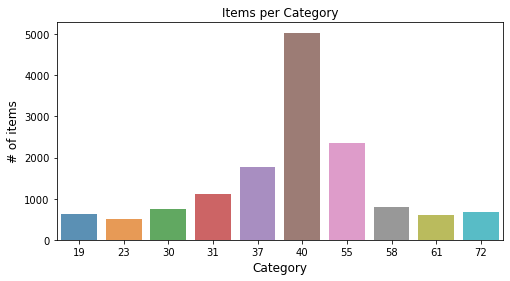

In [23]:
# plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title('Items per Category')
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

## Single series:

The objective requires us to predict sales for the next month at a store-item combination.

Scales over time of each store-item is a time-series in itself.

Here, let us predict for the total sales per month for the entire company.

Firt let us compute the total sales per month and plot the data.

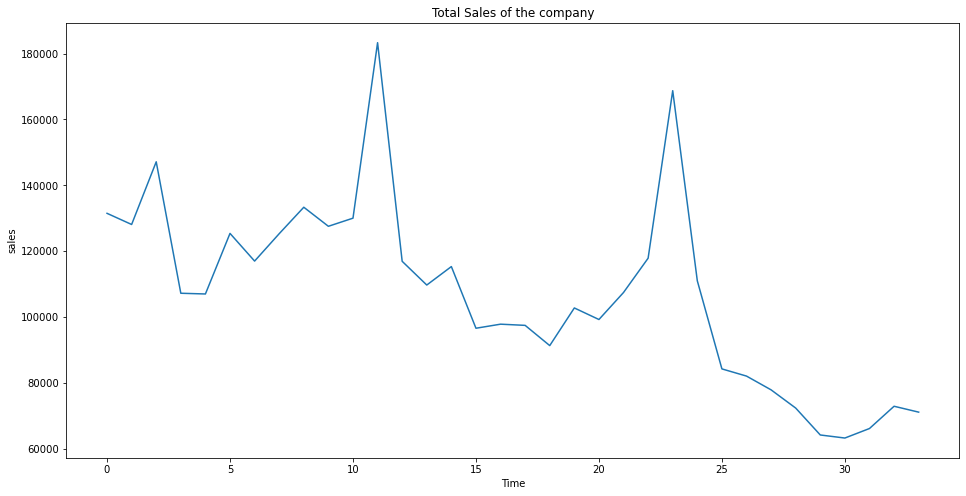

In [28]:
ts = sales_data.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('sales')
plt.plot(ts)

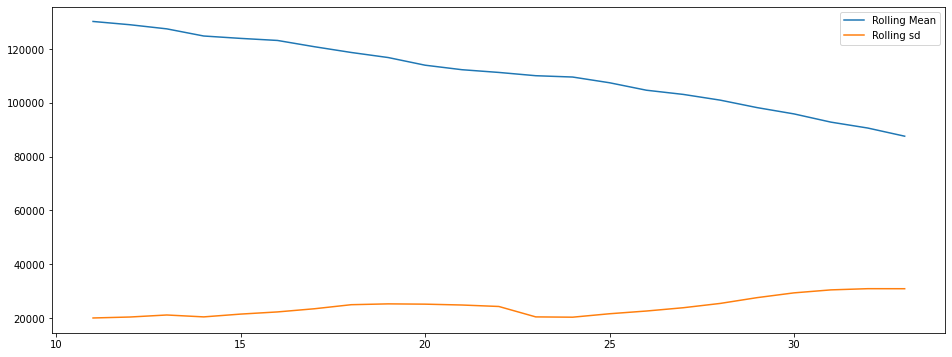

In [29]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

#### Observation: 
There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let us check that with a quick decomposition into Trend, seasonality and residuals.

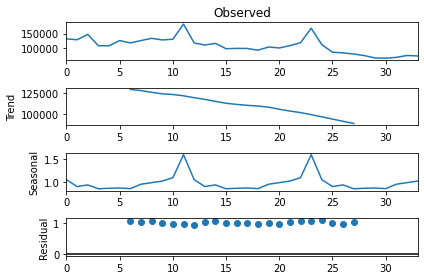

In [30]:
import statsmodels.api as sm
#multiplicative
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model='multiplicative')
#plt.figure(figsize=(16,12))
fig = res.plot()

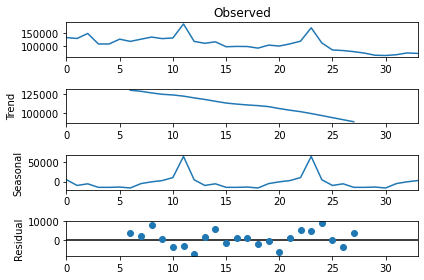

In [31]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

we assume an additive model, then we can write

yt=St+Tt+Et

where yt is the data at period t, St is the seasonal component at period t, Tt is the trend-cycle component at period tt and Et is the remainder (or irregular or error) component at period t Similarly for Multiplicative model,

yt=St x Tt x Et

### Stationarity:

What does it mean for data to be stationary?

1. The mean of the series should not be a funtion of time. the red graph is not stationary because the mean increases over time.

![](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=750w)

Stationary refers to time-invariance of a series i.e. Two points in a time series are related to each other by only how far apart they are, and not by the direction (forward/backward)

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.

There are multiple tests that can be used to check stationarity.

* ADF (Augmented DIcky Fuller Test)
* KPSS
* PP (Phillips-Perron test)

We will perform the ADF which is the most commonly used one.


## Augmented Dickery Fuller Test

It is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series.

### What is a Unit Root Test?

The ADF test belongs to a category of tests called 'Unit Root test' which is the proper method for testing the stationarity of a time series.

So what does 'Unit Root' mean?

Unit root is a characteristic of a time series that makes it non-stationary. Technically speaking, a unit root is said to exist in a time series value of alpha =1 in the below eqn.
![](https://www.machinelearningplus.com/wp-content/uploads/2019/11/equation_1.png)

where, Yt is the value of the time series at time 't' and Xe is an exogenous variable (a separate explanatory variable, which is also a time series).

The presence of a unit root means that the time series is non-stationary. Besides the number of unit roots contained in the series corresponds to the number of differencing operations required to make the series stationary.

Let us come back to the topic ADF. But, before that let us understand what is the Dickery-Fuller test. A Dickery Fuller test is a unit root test that tests the mull hypothesis that  α=1 in the following model eqn alpha is the coefficient of the first lag on y.

Null Hypothesis (HO): alpha = 1

![](https://www.machinelearningplus.com/wp-content/uploads/2019/11/equation_2.png)

where,
y(t-1) = lag 1 of time series
delta Y(t-1) = first difference of the series at time (t-1)

Fundamentally, it has a similar null hypothesis as the unit root test. i.e. the coefficient of Y(t-1) is 1, implying the presence of a unit root. If not rejected, the series is taken to be non-stationary.

As the name suggest, the ADF test is an ‘augmented’ version of the Dickey Fuller test.

The ADF test expands the Dickey-Fuller test equation to include high order regressive process in the model.

![](https://www.machinelearningplus.com/wp-content/uploads/2019/11/equation_3.png)
If you notice, we have only added more differencing terms, while the rest of the equation remains the same. This adds more thoroughness to the test.

The null hypothesis however is still the same as the Dickey Fuller test.

A key point to remember here is: Since the null hypothesis assumes the presence of unit root, that is α=1, the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. Thereby, inferring that the series is stationary.

However, this is a very common mistake analysts commit with this test. That is, if the p-value is less than significance level, people mistakenly take the series to be non-stationary.

The statsmodel package provides a reliable implementation of the ADF test via the adfuller() function in statsmodels.tsa.stattools. It returns the following outputs:

The p-value
The value of the test statistic
Number of lags considered for the test
The critical value cutoffs.
When the test statistic is lower than the critical value shown, you reject the null hypothesis and infer that the time series is stationary.

In [36]:
# Stationarity tests

def test_stationarity(timeseries):
    # Perform ADF test
    print('Result of ADF Test: ')
    adftest = adfuller(timeseries, autolag='AIC')
    adfoutput = pd.Series(adftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    print(adfoutput)

In [37]:
test_stationarity(ts)

Result of ADF Test: 
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64
